In [9]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils

from keras import backend as K
K.set_image_data_format('channels_first')

In [10]:
ls ./frames

2018-04-21-20-41-25/


In [11]:
# Set up some parmaeters for data loading

#Plug in training dir

#Other user
#TRAIN_DIR = './frames/something..etc/'

#Andy
TRAIN_DIR = './frames/2018-04-21-20-41-25/'

#Conor
#TRAIN_DIR = './frames/something..etc/'

sample_rate = 0.1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 3848
Processed 1000 of 3848
Processed 2000 of 3848
Processed 3000 of 3848
Train shape: (3848, 1, 64, 64)


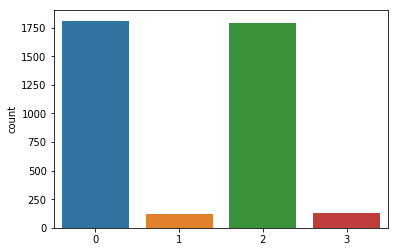

In [12]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

### Show some screens
Print a few screens with their labels.

0


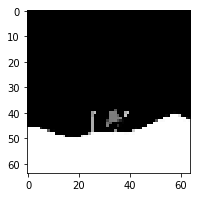

2


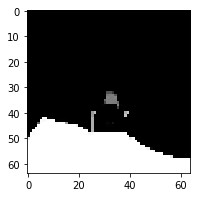

0


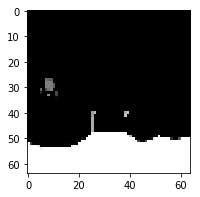

0


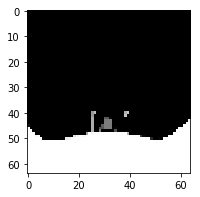

0


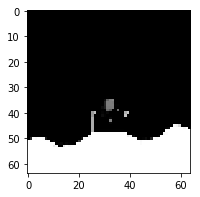

In [13]:
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

### Partition the dataset for evaluation
Split the data into a training and test partition so we can evaluate at the end

In [14]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

Apply under sampling to balance the training dataset

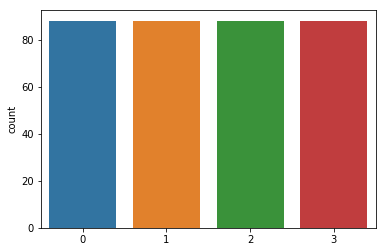

In [15]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

In [20]:
#Build Keras Model
def build_fn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_fn, verbose=1)

In [32]:
#depending on layers added in build function, search free parameters
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

param_grid = {
    "epochs":list(range(5,6,5)),   
    "batch_size":[2**i for i in range(4,5)], #powers of 2
    #"validation_split":[0.1,],
    #"optimizer":['SGD', 'RMSprop', 'Adagrad', 'Adam'],
    #"shuffle":[True],
    #"activation":['relu', 'softmax'],
    #"dropout_rate":[0.1]
    #Learning rate
    #momentum etc.
    #init_mode #initial weightings
}

grid = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   n_jobs=1,
                   verbose=1,
                   refit=True,
                   scoring=metrics.accuracy_score)
history = grid.fit(train_rus, train_labels_rus_wide )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min finished


In [34]:
#history.best_parameters_
history.best_estimator_


Plot the evolution of the loss as the module was trained.

In [27]:
loss = history.best_estimator_.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

AttributeError: 'KerasClassifier' object has no attribute 'history'

In [ ]:
# Regularisation: stop where training loss and validation loss curves diverge.
# Use early stopping to roll-back

In [ ]:
epochs = 20
batch_size = 128 #power of 2 to take advantage or comp architecture

history = model.fit(train_rus, train_labels_rus_wide, 
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.25, 
                    verbose=1, 
                    shuffle=True)

### Evaluate the Model
Use the test dataset to evaluate the model

In [ ]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = model.predict_classes(test)

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

#Accuracy
print(metrics.accuracy_score(test_labels, pred))

### Persist A Model
Save the model

In [ ]:
filepath = "player.mod"
model.save(filepath)

Load a saved model

In [ ]:
model = keras.models.load_model("player.mod")

Train, test a new model that just takes pixels and labels, like MNist problem.
Try some different learners.